# SAPHIRES - Coude Spectra and the BF!

### This is a demo showing how to manipulate the McDonald 2.7m Coude spectra we have for the SSG/RS CVn candidates within the SAPHIRES framework written by Ben Tofflemire and Emily Leiner

# The Data
### Data for each SSG is contained in a folder named for the star (e.g. V846Her). Each folder contains both the reduced spectra and the some SAPHIRES data products (SAPHIRES is a python package we will be using for spectral analysis and will install below). 

### Reduced: A spectrum for each night the target was observed (starname_date_nightlyindex.pkl; this is a python pickle) and an associated .ls file. The .ls file is used to read the spectrum into saphires, it tells saphires which orders and what parts of a given order to consider. This .pkl file has the full spectrum. If you are interested in an emission line you have to look here, but the data products below have most of the specrtum and a lot of other useful things, like the pre-comupted BF. You may not need to mess with these files, depending on your use case. 

### Data Products: For each epoch there is a .p file that has been run through the saphires framework and has a precomputed BF for the orders we've considered (starname_date_nightlyindex_tempteff_templogg.p; this is a python pickle). 

### Others: There is also a .dat file which lists all the observations and important information about the time the target was observed. 

### Finally, there is a synthetic model template in each folder that I used to compute the broadening function (BF). I'm including this for repeatability. 












### Before we get started, we will need to install the package SAPHIRES, which provides functions to analyze spectra. If installing locally on your machine, saphires is pip installable. You may need to install some saphires dependencies as well. Below is a pip install command to install saphires as well as barycorrpy, emcee, and corner, all packages saphires needs to run. You can run this command in Jupyter, or execute it in the terminal (without the !). 

### If you wish to run in colab this step will be a bit more complicated because colab does not support interactive plotting functionality. We do not need SAPHIRES installed for this week's analysis, but we WILL need it next week. I will post instructions on using SAPHIRES in colab on blackboard, but you might consider getting your local install of anaconda/Jupyter working before then if you have not yet. 

In [1]:
#installing saphires and other dependences. You only need to run once, comment out once done
#!pip install saphires barycorrpy emcee corner

In [1]:
#import packages. 
#Note that if you get an error when importing saphires that certain packages are not found, 
#you'll need to pip install them as well
import numpy as np
import os
from scipy.optimize import curve_fit
import matplotlib
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.pyplot as plt
import pickle as pkl
from scipy.ndimage import gaussian_filter
import scipy
%matplotlib inline 

In [2]:
#Constants
R_coude = 60000.0 #spectral resolution of the Coude. 
c = (2.9979245*10**5) #speed of light

### 1) First, lets take a look at the reduced spectrum for a star. There will be several different observations of your star-- just pick one observations to stars. Below, I will show an example of how to read in and look at a spectrum for the example star V846Her. You should adapt the code as necessary to look at your assigned star. 

In [3]:
spec = pkl.load(open('/Users/edinpeskovic/Documents/research summer 2024/Spectroscopy Lab/coude_SSG_data/V846Her/V846Her_2020-05-10_0.pkl','rb'))

In [4]:
#you can see that the file we read in contains wavelength, flux, and object ID
spec.keys()

dict_keys(['wav', 'flux', 'object'])

In [5]:
print(spec['wav'].shape)
#you can see this is a multi-dimensional array, it contains 58 different spectral orders, 
#each with 2048 pixels of wavelength information
for i in range(spec['wav'].shape[0]):
    print(i,spec['wav'][i,0],spec['wav'][i,-1])

(58, 2048)
0 3746.1150515109207 3808.677713522406
1 3787.776435477675 3851.0417117069055
2 3830.3655425470024 3894.327956692886
3 3873.915915426664 3938.616195658037
4 3918.462501486428 3983.904369193745
5 3964.066266565585 4030.258736147322
6 4010.729171214878 4077.690745848745
7 4058.503374851372 4126.274111697992
8 4107.424411929961 4176.001062846046
9 4157.532798547371 4226.932955011314
10 4208.8775289201085 4279.133309426227
11 4261.510390327277 4332.651520194947
12 4315.457623820385 4387.492927451705
13 4370.8153587465495 4443.762310802915
14 4427.580240384749 4501.477305832738
15 4485.840047601198 4560.714774699517
16 4545.691209490884 4621.543163555878
17 4607.128614610773 4683.995751982033
18 4670.247667945626 4748.1713967438045
19 4735.125938705471 4814.125847988397
20 4801.824041784164 4881.949233698815
21 4870.427717559616 4951.679186734384
22 4941.020479572862 5023.439812422926
23 5013.690604547827 5097.33020073355
24 5088.527038389699 5173.4023957122245
25 5165.6222129845

### 2) Lets start by looking at the H-alpha line, which has a rest frame wavelength at 6562.8 Angstroms. 

Text(0.5, 1.0, 'V846Her spectrum')

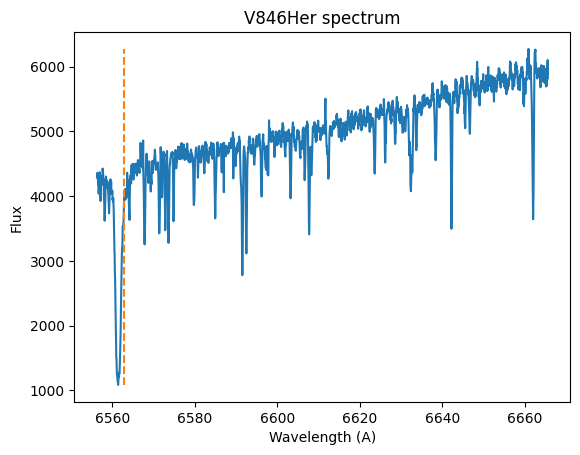

In [6]:
#from above, looks like H-alpha is in order 39
o_ha = 39
l_ha= 6562.8

fig,ax = plt.subplots(1)

ax.plot(spec['wav'][o_ha],spec['flux'][o_ha])
ax.plot([l_ha, l_ha], (min(spec['flux'][o_ha]), max(spec['flux'][o_ha])), '--')
ax.set_ylabel('Flux')
ax.set_xlabel('Wavelength (A)')
ax.set_title('V846Her spectrum')

#There should be a strong absorption or emission line close to the rest frame wavelength of H-alpha marked in orange, 
#but it should be red-shifted or blue shifted slightly relative to the rest frame H-alpha line 
#because of the star's radial velocity. If you don't see a clear feature here, try selecting a different observation. 
#Observing conditions will vary between nights and some spectra look better than others. 

/var/folders/kf/v0g3d6kx2cjf48cdq0s3lxyc0000gn/T/ipykernel_1395/1225260286.py:15: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


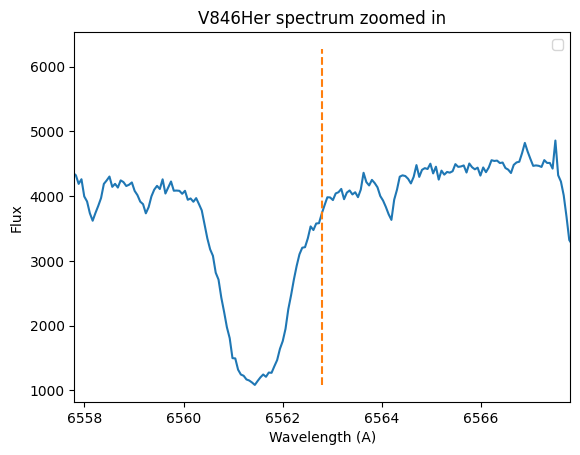

In [7]:
#now zoom in on the H-alpha spectral region
fig,ax = plt.subplots(1)

ax.plot(spec['wav'][o_ha],spec['flux'][o_ha])

ax.set_ylabel('Flux')
ax.set_xlabel('Wavelength (A)')
ax.plot([l_ha, l_ha], (min(spec['flux'][o_ha]), max(spec['flux'][o_ha])), '--')


ax.set_xlim(l_ha-5, l_ha+5)
ax.set_title('V846Her spectrum zoomed in')


ax.legend()
#H-alpha appears to be blue shifted by about 1.4 Angstroms

### 3) We want to fit this H-alpha line profile with a gaussian function. To do that, define a function that takes a gaussian function and adds a constant to it (the continuum). 
### $$y= Ae^\frac{-(x-\mu)^2}{2\sigma^2}+B$$
### where $\mu$ is the mean of the gaussian, $\sigma$ is the standard deviation of the gaussian, A is the amplitude, and B is a constant that represents the flux from the stellar continuum.  

In [8]:
#define your gaussian function here by filling in the return statement with your equation
def gauss(x, *p): 
    A, mu, sigma, B = p
    return A*np.exp(-1*(((x-mu)**2)/(2*sigma**2)))+B

### 4) Now we will fit a gaussian to the H-alpha line above. To do this, first cut out a section of the spectral data right around the H-alpha line. You will want to select a wavelength range wide enough that it spans the width of the entire absorption line plus some continuum flux on either side of the line since our function is fitting the continuum level. Then use scipy.optimize.curve_fit() and the function you made above to fit a gaussian to this section of the spectrum. To do this you to pass your x data (wavelength) and y data (flux) to curve_fit, as well as an initial guess for p. 

In [10]:
cond1_Ha = spec['wav'][o_ha] > 6559.
cond2_Ha = spec['wav'][o_ha] < 6564
Ha_feat = np.where(cond1_Ha & cond2_Ha)

popt_Ha, pcov_Ha = scipy.optimize.curve_fit(gauss, spec['wav'][o_ha][Ha_feat], spec['flux'][o_ha][Ha_feat], p0 = [-3000, 6561.4, 2, 4000])
print(popt_Ha)

[-3.16840719e+03  6.56147323e+03 -6.07458600e-01  4.11952952e+03]


### 5) To check whether your fit is working well, plot your spectrum zoomed in on the H-alpha region and overplot your best fit gaussian. 

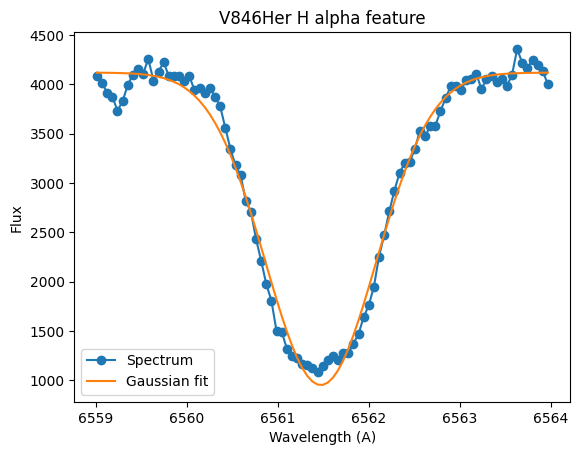

In [25]:
fig, ax = plt.subplots(1)

ax.plot(spec['wav'][o_ha][Ha_feat], spec['flux'][o_ha][Ha_feat], '-o', label = 'Spectrum')
ax.set_xlabel('Wavelength (A)')
ax.set_ylabel('Flux')
ax.set_title('V846Her H alpha feature')

ax.plot(spec['wav'][o_ha][Ha_feat], gauss(spec['wav'][o_ha][Ha_feat], *popt_Ha), label = 'Gaussian fit')

ax.legend()

### 6) Lets take a look at best-fit value for $\mu$. This tells you the observed central wavelength of the H-alpha line. This allows us to compute the radial velocity of our star by comparing it to the rest-frame wavelength of H-alpha. Recall that 
### $$z= \frac{v}{c}= \frac{\lambda_{obs}-\lambda_{emit}}{\lambda_{emit}}$$
### where z is redshift, v is the radial velocity of the star, c is the speed of light, and $\lambda_{obs}$ and $\lambda_{emit}$ are the observed and rest frame wavelengths of a line, respectively. 

### Use this info to compute the radial velocity of your star from the H-alpha line. Note that later we will use many lines to fit the RV much more precisely, but this is a first pass to get an approximate redshift for our star.  

In [12]:
#take best fit val of mu; it is the best fit center of the H alpha feature.
#can compute radial velocities of stars using the observed wavelength of the H alpha 
#feature compared to the expected (rest-frame) wavelength of the H alpha feature 

def redshift(lambda_obs, lambda_emit, starname): 
    z = (lambda_obs - lambda_emit)/lambda_emit
    return z

z = redshift(popt_Ha[1], l_ha, '846Her')

def radvel(z, starname):
    v = z*c
    return v

v = radvel(redshift(popt_Ha[1], l_ha, '846Her'), '846Her')

print('redshift is z=', z, 'and the radial velocity is v=', v)

redshift is z= -0.00020216536714432452 and the radial velocity is v= -60.60765072134655


### 7) Lets find the equivalent width of the H-alpha line. This is a useful way to measure the line strength of this feature, which is an indicator of the magnetic field strength in the star. 

$$EW= \int_{\lambda_1}^{\lambda_2}{\frac{Fc-Fs(\lambda)}{Fc}d\lambda}$$
where Fc is the continuum flux (B from your gaussian fit) and Fs is observed flux inside the emission/absorption feature 

### Therefore, you must integrate to find the EW. You might use your actual spectral data and do a numerical integration, or you could integrate the gaussian function you fit to your line profile. Think about which approach would work best. (Recall that we did some numerical integration in Lab 3, which you may find helpful to look back at). Remember to include units when you report your measurement

In [13]:
#Equivalent width is useful to measure line strength -> line strength: indicator of mad field strength
#Fc is the gaussian fit of continuum flux
#Fs is observed flux: is it the amplitude of the H alpha feature or the observed continuum? we'll find out

Fs_quad_Ha = scipy.integrate.quad(lambda x: gauss(x, *popt_Ha), spec['wav'][o_ha][Ha_feat][0], spec['wav'][o_ha][Ha_feat][-1])
print(Fs_quad_Ha)

EW_quad_Ha = (spec['wav'][o_ha][Ha_feat][-1] - spec['wav'][o_ha][Ha_feat][0])-(Fs_quad_Ha[0]/popt_Ha[3])
print('The equivelent width is', EW_quad_Ha)

#Fs_trap = scipy.integrate.trapezoid(gauss, spec['wav'][o_ha][Ha_feat])

(15575.931852508245, 4.629308758552497e-08)
The equivelent width is 1.1710621689104412


### 8) Now lets check and see if we can see a lithium feature in our spectra. Lithium is typically destroyed by convection in giant stars, so any significant lithium lines would be interesting to note. Lets check to see if there is a line in the location we would expect for Lithium, 6707.8 Angstroms in the rest frame. Remember that this line will be slightly shifted from the rest frame due to the radial velocity of the star. A good way to help identify your lithium line is to check a high resolution solar Atlas and look at your region of interest (5-10 Angstroms on either side of the line you want to find). https://bass2000.obspm.fr/solar_spect.php

### Make a plot zoomed in on the lithium feature in your star. What we would like to know is whether lithium looks much stronger or much weaker than the lithium line in the sun. One way you can assess the line strength by eye is to compare the strength of the lithium feature to other nearby lines ( a line ratio). Right next to the lithium feature is a series of several Fe I lines. Compare the line strength of the Li line to the Fe features... Is lithium stronger, weaker, or about the same? How about in the solar atlas-- is lithium much stronger, much weaker, or about the same? 

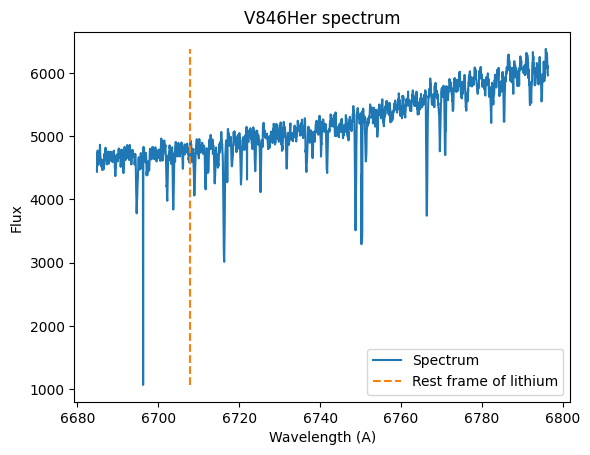

In [14]:
o_li = 40
l_li = 6707.8 #angstrom

fig, ax = plt.subplots(1)

ax.plot(spec['wav'][o_li], spec['flux'][o_li], label = 'Spectrum')
ax.plot([l_li, l_li], (min(spec['flux'][o_li]), max(spec['flux'][o_li])), '--', label = 'Rest frame of lithium')
ax.set_xlabel('Wavelength (A)')
ax.set_ylabel('Flux')
ax.set_title('V846Her spectrum')
ax.legend()

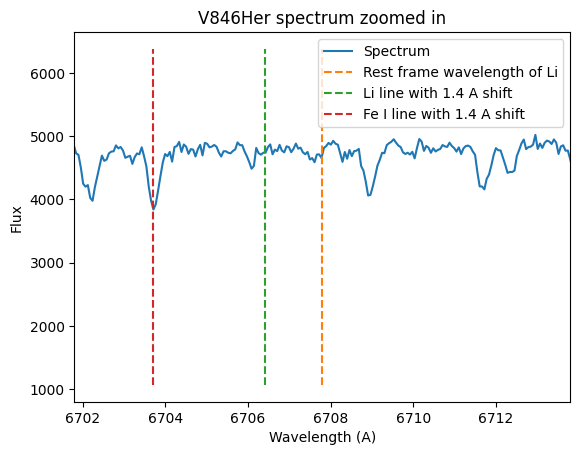

In [24]:
fig, ax = plt.subplots(1)

ax.plot(spec['wav'][o_li], spec['flux'][o_li], label = 'Spectrum')
ax.plot([l_li, l_li], (min(spec['flux'][o_li]), max(spec['flux'][o_li])), '--', label = 'Rest frame wavelength of Li')
ax.plot([6706.4, 6706.4], (min(spec['flux'][o_li]), max(spec['flux'][o_li])), '--', label = 'Li line with 1.4 A shift')
ax.plot([6703.7, 6703.7], (min(spec['flux'][o_li]), max(spec['flux'][o_li])), '--', label = 'Fe I line with 1.4 A shift')


ax.set_xlabel('Wavelength (A)')
ax.set_ylabel('Flux')
ax.set_title('V846Her spectrum zoomed in')
ax.legend()

ax.set_xbound(l_li-6, l_li+6)

In [16]:
#Eyeballing it, the lithium feature in 486Her blends in with the 
#continuum while the lithium feature in the sun has a very small 
#absorption feature. After some time, thinking, looking, and research,
#we know that the sun has a noticeable absence of lithium and comparing
#it to the spectrum of V846Her, we see that they BOTH lack a lithium 
#feature. To make sure, I will guessitmate the intensities of the where
#lithium features and Fe I features and as described above, I will test
#the line ratios.

I_Sun_Li = 9900-9788
I_Sun_Fe = 9900-6002

I_V846Her_Li = 4900 - np.interp(6707.4, spec['wav'][o_li], spec['flux'][o_li])
I_V846Her_Fe = 4900 - np.interp(6703.7, spec['wav'][o_li], spec['flux'][o_li])

LiFeSun_ratio = I_Sun_Li/I_Sun_Fe
LiFeV846Her_ratio = I_V846Her_Li/I_V846Her_Fe

print('Ratio of the Li line to FeI line in the sun is', LiFeSun_ratio)
print('Ratio of the Li line to FeI line in V846Her is', LiFeV846Her_ratio)

#Just eyeballing it, it is very obvious that the Lithium feature is much 
#weaker than the Fe I feature in the sun, and it is shown in the line ratio.
#In the spectrum for V846Her, it is obvious to  see that the Fe I & Li feature
#are MUCH smaller than the sun's Fe I and Li feature. The line ratio of Fe I to
#Li show how much weaker both the lines are and have a comparatively larger ratio
#because of the weaker Li and Fe I features.

#All this to say, in the sun, Li is weaker, MUCH weaker than the Fe I line, and in 
#V846Her, the Li is weaker than the Fe I line, but less weak than the sun
#The line ratio in V846Her of Li to Fe I is higher than in the sun

Ratio of the Li line to FeI line in the sun is 0.028732683427398667
Ratio of the Li line to FeI line in V846Her is 0.17025197035492742


### 9) Lets take a look at barium in our stars. Barium is an s-process element that is produced inside AGB stars. Strong barium lines in a sub-subgiant would indicate the star may have been polluted by mass transfer from an AGB companion star. A well-known barium line is located at 4554 angstroms. As you did for lithium, compare the line strength of barium to some nearby lines. Are the line ratios similar to what you see in the solar spectrum? 

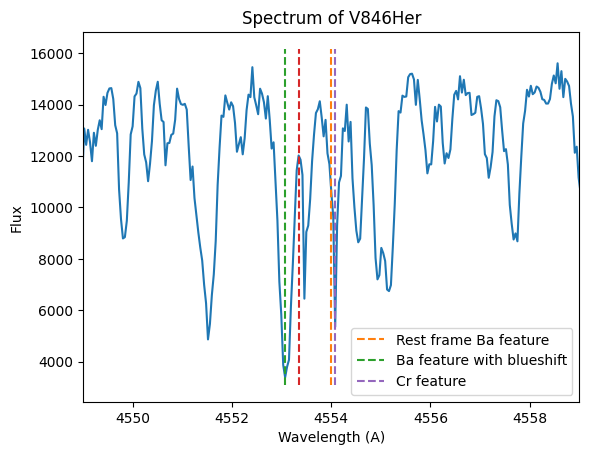

In [17]:
o_ba = 16 #looking at the spectral orders, the barium feature seems to be at order 16
l_ba = 4554 #in angstrom

fig, ax = plt.subplots(1)

ax.plot(spec['wav'][o_ba], spec['flux'][o_ba]) 
ax.plot([l_ba, l_ba], (min(spec['flux'][o_ba]), max(spec['flux'][o_ba])), '--', label = 'Rest frame Ba feature')
ax.plot([l_ba-0.93, l_ba-0.93], (min(spec['flux'][o_ba]), max(spec['flux'][o_ba])), '--', label = 'Ba feature with blueshift')
ax.plot([l_ba-0.65, l_ba-0.65], (min(spec['flux'][o_ba]), max(spec['flux'][o_ba])), '--')

ax.plot([l_ba+0.07, l_ba+0.07], (min(spec['flux'][o_ba]), max(spec['flux'][o_ba])), '--', label = 'Cr feature')
ax.set_ylabel('Flux')
ax.set_xlabel('Wavelength (A)')
ax.set_title('Spectrum of V846Her')
ax.set_xbound(l_ba-5,l_ba+5)
ax.legend()

In [18]:
I_V846Her_Ba = np.interp(4553.07, spec['wav'][o_ba], spec['flux'][o_ba]) #gives the flux when wavelength inputted
I_V846Her_Cr = np.interp(l_ba+0.07, spec['wav'][o_ba], spec['flux'][o_ba]) #gives the flux when wavelength inputted

I_Sun_Ba = 9900-590 #in angstroms; we are subtracting the continuum from the intensity
I_Sun_Cr = 9900-4889 #in angstroms; we are subtracting the continuum from the intensity

BaCrSun_ratio = 14400 - I_Sun_Ba/I_Sun_Cr #in angstroms; we are subtracting the continuum from the intensity
BaCrV846Her_ratio = 14400 - I_V846Her_Ba/I_V846Her_Cr #in angstroms; we are subtracting the continuum from the intensity

print('The ratio of Ba to Cr in the sun is', BaCrSun_ratio)
print('The ratio of Ba to Cr in V846Her is', BaCrV846Her_ratio)

#The line ratio between Ba and Cr in V846Her is about the same as in the sun

The ratio of Ba to Cr in the sun is 14398.142087407703
The ratio of Ba to Cr in V846Her is 14399.46218050777


### 10) If you can see a distinct barium and/or lithium feature, can you measure an equivalent width for it? This may be more challenging than fitting H-alpha, as these lines are usually much weaker and may be blended with other nearby features. 

In [19]:
#We see a very distinct Ba feature, so we'll measure the EW here

cond1_Ba = spec['wav'][o_ba] > 4552.6 #setting the condition for the minimum bound to isolate the Ba feature
cond2_Ba = spec['wav'][o_ba] < 4553.4 #setting the condition for the minimum bound to isolate the Ba feature
Ba_feat = np.where(cond1_Ba & cond2_Ba) #the bounds of the Ba feature 

popt_Ba, pcov_Ba = scipy.optimize.curve_fit(gauss, spec['wav'][o_ba][Ba_feat], spec['flux'][o_ba][Ba_feat], p0 = [-5000, 4553.07, 1, 14000]) #
print(popt_Ba)

[-1.06216452e+04  4.55308610e+03  1.34415836e-01  1.39671389e+04]


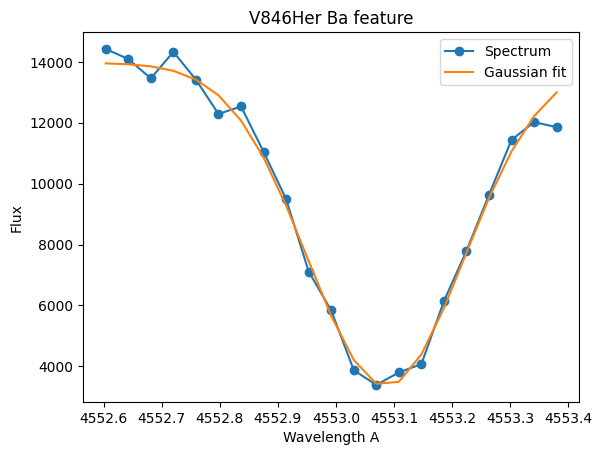

In [22]:
fig, ax = plt.subplots(1)

ax.plot(spec['wav'][o_ba][Ba_feat], spec['flux'][o_ba][Ba_feat], '-o', label = 'Spectrum')
ax.set_xlabel('Wavelength A')
ax.set_ylabel('Flux')
ax.set_title('V846Her Ba feature')

ax.plot(spec['wav'][o_ba][Ba_feat], gauss(spec['wav'][o_ba][Ba_feat], *popt_Ba), label = 'Gaussian fit')

ax.legend()

In [21]:
Fs_quad_Ba = scipy.integrate.quad(lambda x: gauss(x, *popt_Ba), spec['wav'][o_ba][Ba_feat][0], spec['wav'][o_ba][Ba_feat][-1])
print(Fs_quad_Ba)

EW_quad_Ba = (spec['wav'][o_ba][Ba_feat][-1] - spec['wav'][o_ba][Ba_feat][0])-(Fs_quad_Ba[0]/popt_Ba[3])
print('The equivelent width is', EW_quad_Ba)

(7323.214662769746, 8.130401538651577e-11)
The equivelent width is 0.25251282950435217


# Once you are satisfied with your calculations and plots, save plots of your H-alpha, lithium, and barium lines. Clearly mark which line is from lithium, barium, or H-alpha. Note your H-alpha equivalent width measurement somewhere on the H-alpha plot (and barium and lithium EWs if you have them). Merge all your plots into a single pdf and upload them to blackboard to complete your Lab 6 Part 1 project updated. 

## 11) If you have time, take a look at some more observations of your star. Do the equivalent widths of these lines stay similar between observations, or do they vary? You can average the EWs of the lines in each observation to determine the EW and take the standard deviation to determine an error on your measurement.
